Creating Auction Prediction Model... again. 


Starting Auction Model Training Pipeline
Loading auction data...
Data loaded: 3422 records
Columns: ['catalogue_no', 'auction_date', 'plant', 'plant_code', 'scode', 'state', 'h1_buyer_name', 'proposed_rp', 'quantity', 'auctuom', 'last_bid_price', 'total_amt', 'material_code', 'productdescription', 'product_group', 'year', 'month', 'day_of_week', 'day_of_month', 'week_of_year']

--- Outlier Analysis: Cylinders - proposed_rp ---


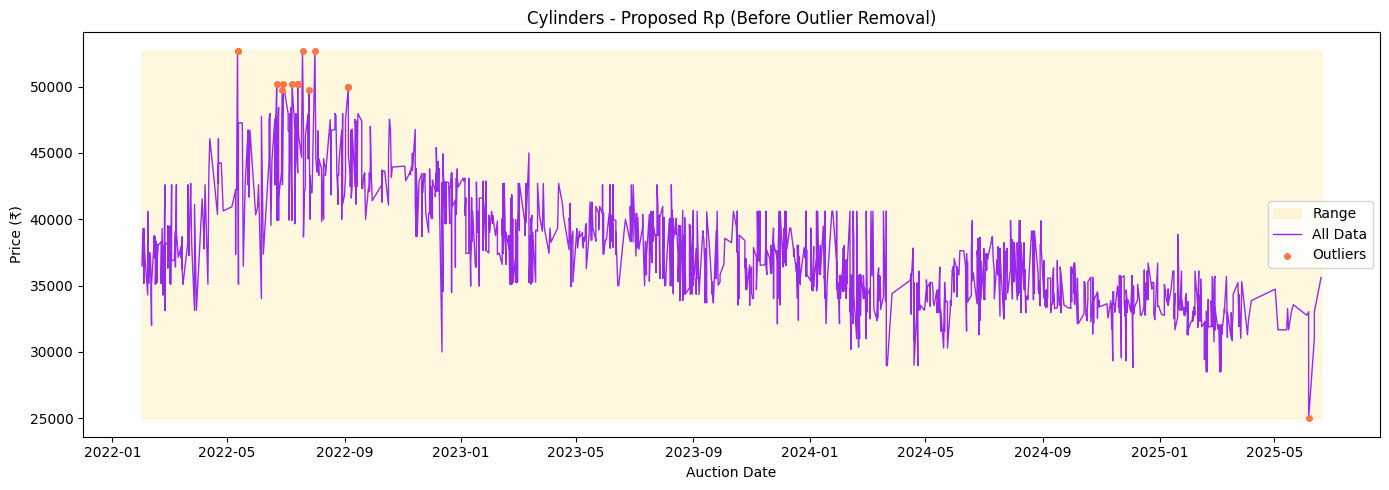

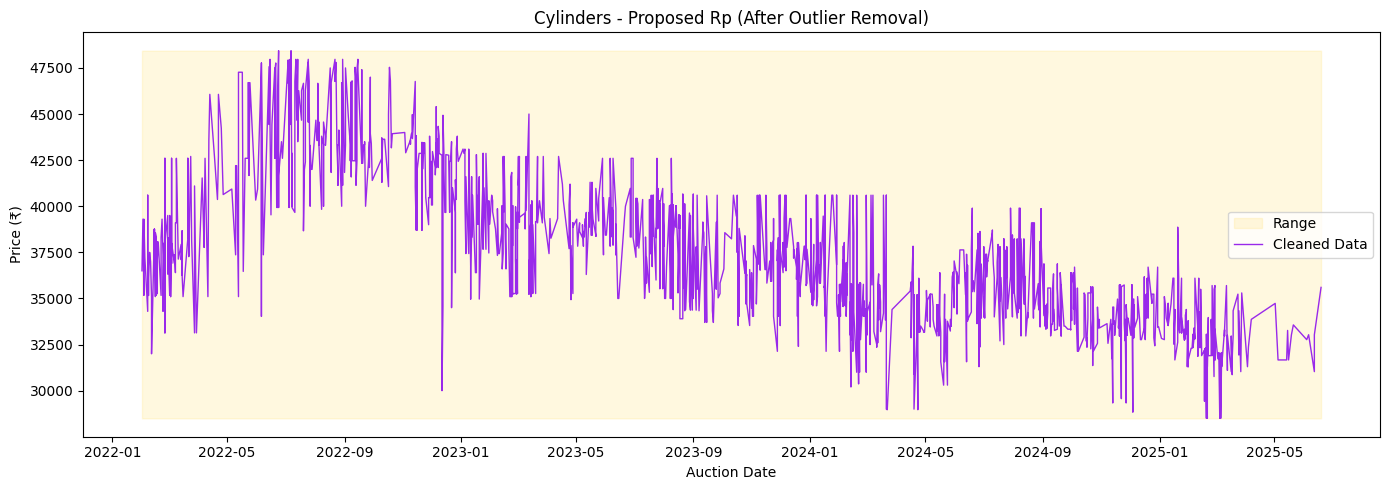

  Outliers removed: 15 / 2277 (0.66%)
  Cleaned records: 2262

--- Outlier Analysis: Cylinders - last_bid_price ---


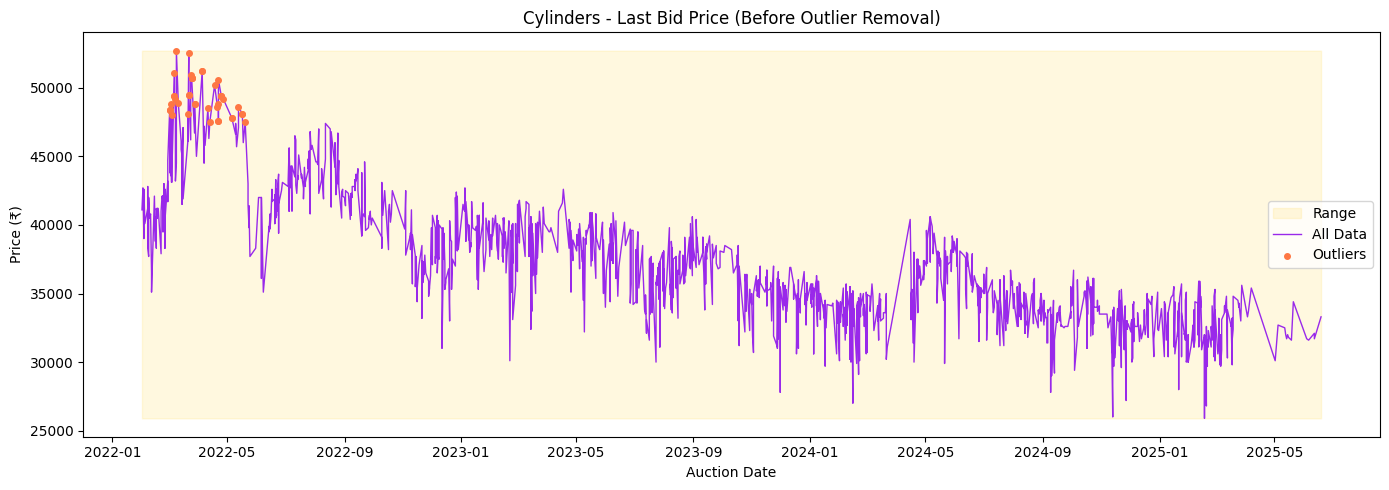

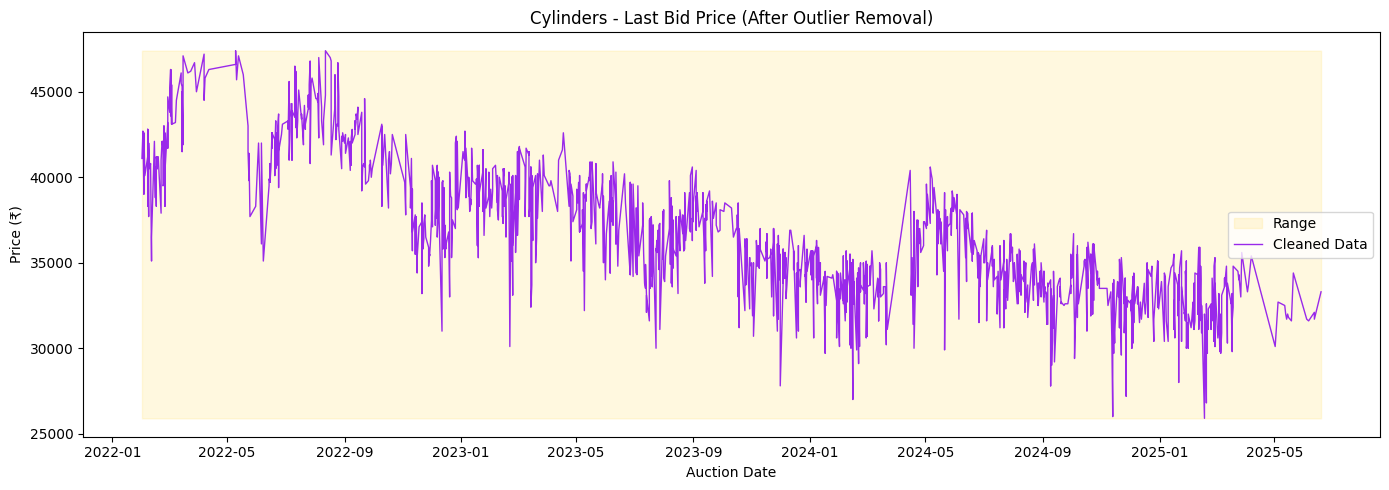

  Outliers removed: 41 / 2262 (1.81%)
  Cleaned records: 2221

--- Outlier Analysis: Valves - proposed_rp ---


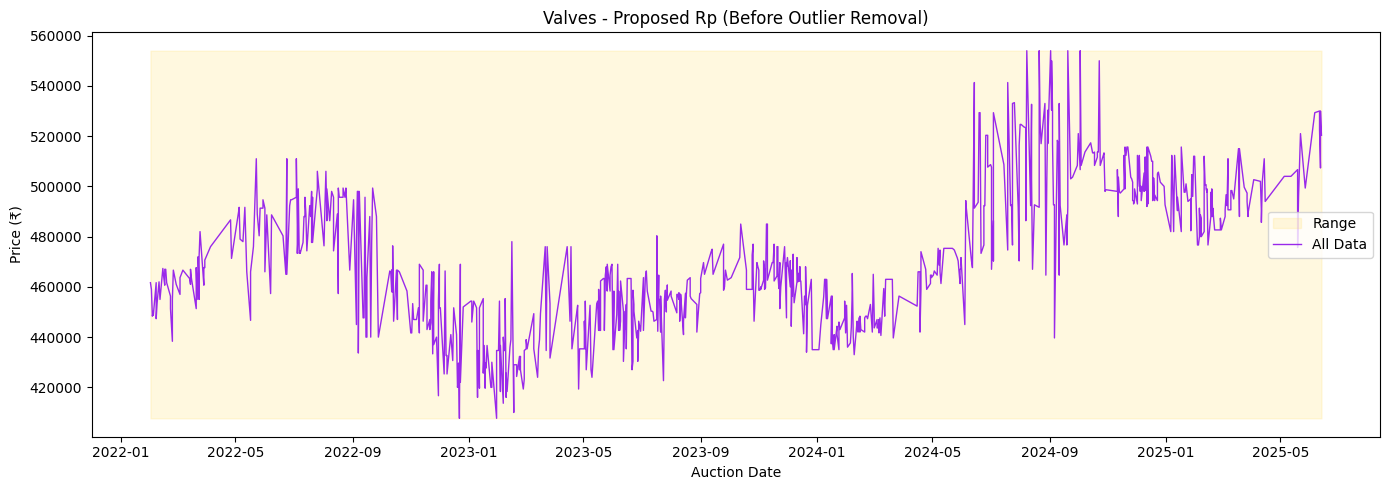

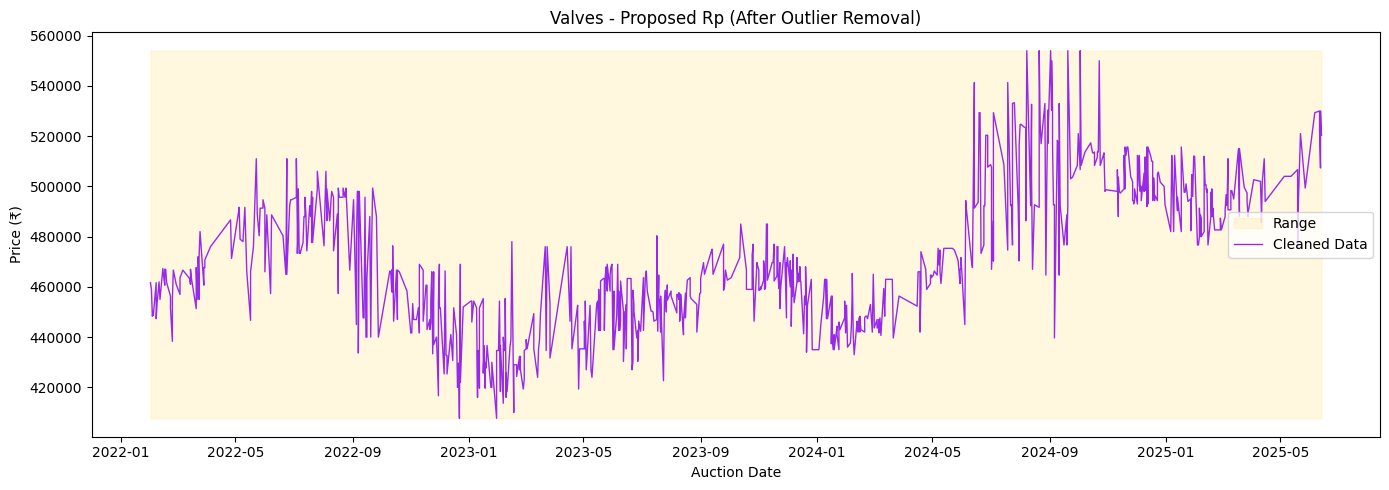

  Outliers removed: 0 / 805 (0.00%)
  Cleaned records: 805

--- Outlier Analysis: Valves - last_bid_price ---


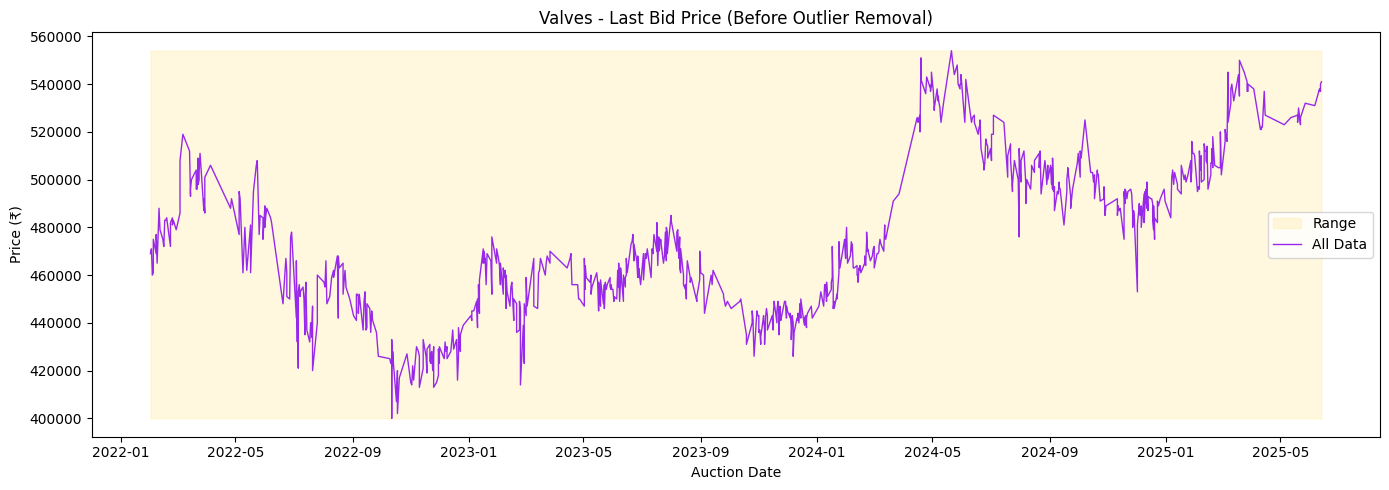

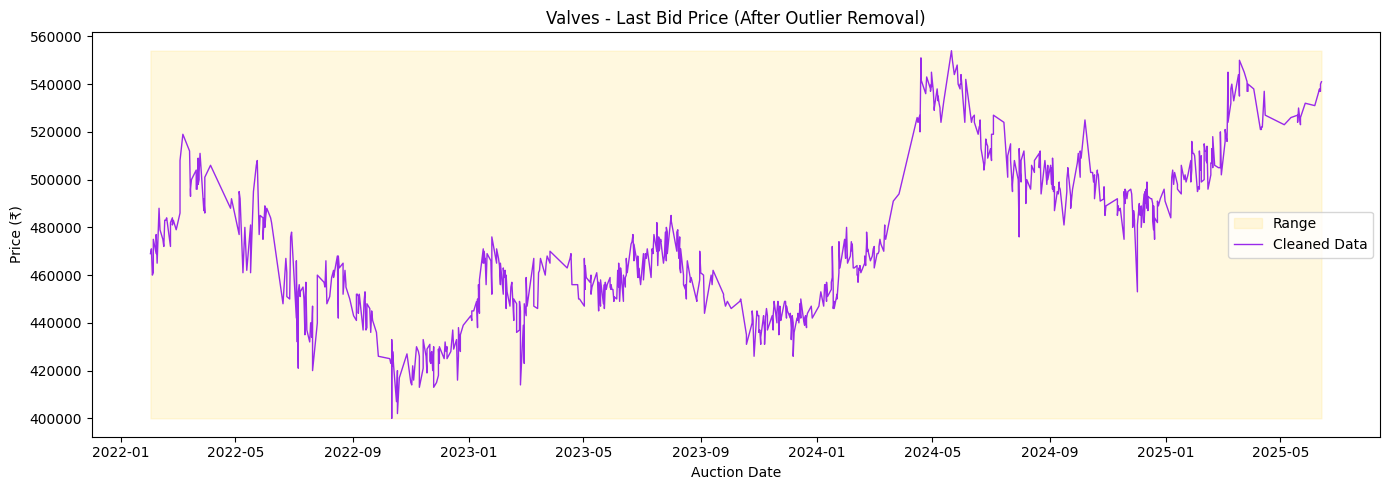

  Outliers removed: 0 / 805 (0.00%)
  Cleaned records: 805

Final cleaned data: 3366 records
Training all models...
Preparing data with temporal features...
Cylinders: 2221 records
Valves: 805 records
Adding dynamic EWM features for cylinders...
Added dynamic EWM features for 2221 cylinders records
Adding dynamic EWM features for valves...
Added dynamic EWM features for 805 valves records
Cylinder train: 1776, test: 445
Valve train: 644, test: 161

=== Training Cylinder Models ===
Saved preprocessor to: ../models/cyl_preproc.joblib
Saved model to: ../models/cyl_proposed_rp_q5_seed1.joblib
Saved model to: ../models/cyl_proposed_rp_q5_seed2.joblib
Saved model to: ../models/cyl_proposed_rp_q5_seed3.joblib
Saved model to: ../models/cyl_proposed_rp_q10_seed1.joblib
Saved model to: ../models/cyl_proposed_rp_q10_seed2.joblib
Saved model to: ../models/cyl_proposed_rp_q10_seed3.joblib
Saved model to: ../models/cyl_proposed_rp_q25_seed1.joblib
Saved model to: ../models/cyl_proposed_rp_q25_seed2.

In [8]:
#!/usr/bin/env python3
"""
Auction Price Prediction Model Training Script
==============================================

This script trains quantile regression models for auction price prediction
with proper temporal features and chronological data splitting.

Features:
- Dynamic EWM calculation for each prediction date
- Comprehensive temporal features (momentum, volatility, trends)
- Chronological train/test splits (no data leakage)
- Time-series cross-validation
- Support for both cylinders and valves
- Brass index prediction for valves


"""

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

class AuctionModelTrainer:
    def __init__(self, data_path='../data/AuctionData.xlsx'):
        self.data_path = data_path
        self.df = None
        self.cyl_train = None
        self.cyl_test = None
        self.valve_train = None
        self.valve_test = None

        self.CYL_FEATURES = [
            'year', 'month', 'quantity', 
            'ewm_proposed_rp', 'ewm_last_bid_price',
            'day_of_week', 'day_of_month', 'week_of_year',
            'days_since_last_auction', 'auction_frequency_7d',
            'price_momentum_7d', 'price_momentum_30d',
            'quantity_trend_7d', 'quantity_trend_30d',
            'last_auction_price', 'last_auction_quantity',
            'price_volatility_7d', 'price_volatility_30d',
            'rolling_mean_7d_proposed_rp', 'rolling_mean_30d_proposed_rp',
            'rolling_mean_7d_last_bid_price', 'rolling_mean_30d_last_bid_price',
            'rolling_std_7d_proposed_rp', 'rolling_std_30d_proposed_rp',
            'rolling_std_7d_last_bid_price', 'rolling_std_30d_last_bid_price',
            'price_change_1d', 'price_change_7d', 'price_change_30d',
            'quantity_change_1d', 'quantity_change_7d', 'quantity_change_30d'
        ]
        self.VALVE_FEATURES = self.CYL_FEATURES + [
            'brass_index_poly', 'brass_index_momentum_7d',
            'brass_index_momentum_30d', 'brass_index_volatility_7d'
        ]

    def load_and_preprocess_data(self):
        print("Loading auction data...")
        self.df = pd.read_excel(self.data_path)
        self.df.columns = self.df.columns.str.lower()
        self.df['auction_date'] = pd.to_datetime(self.df['auction_date'])
        self._add_product_groups()
        self._add_basic_temporal_features()
        print(f"Data loaded: {len(self.df)} records")
        print(f"Columns: {list(self.df.columns)}")

        # Outlier removal and plotting
        self.df = self.remove_outliers_and_plot(self.df)
        return self.df

    def remove_outliers_and_plot(self, df):
        # For each product group and price column, remove outliers and plot
        for group in ['cylinders', 'valves']:
            for price_col in ['proposed_rp', 'last_bid_price']:
                if price_col not in df.columns:
                    continue
                print(f"\n--- Outlier Analysis: {group.title()} - {price_col} ---")
                group_df = df[df['product_group'] == group].copy()
                if group_df.empty:
                    continue
                # IQR outlier detection
                Q1 = group_df[price_col].quantile(0.25)
                Q3 = group_df[price_col].quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - 1.5 * IQR
                upper = Q3 + 1.5 * IQR
                outlier_mask = (group_df[price_col] < lower) | (group_df[price_col] > upper)
                outliers = group_df[outlier_mask]
                cleaned = group_df[~outlier_mask]

                # Sort by date for line plot
                group_df = group_df.sort_values('auction_date')
                cleaned = cleaned.sort_values('auction_date')
                outliers = outliers.sort_values('auction_date')

                # --- LINE PLOT: BEFORE OUTLIER REMOVAL ---
                plt.figure(figsize=(14, 5))
                # Fill between min/max for visual context
                plt.fill_between(group_df['auction_date'], 
                                group_df[price_col].min(), group_df[price_col].max(), 
                                color='#FFDE63', alpha=0.2, label='Range')
                # Main line
                plt.plot(group_df['auction_date'], group_df[price_col], 
                        color='#9929EA', linewidth=1, label='All Data')
                # Outlier markers
                if not outliers.empty:
                    plt.scatter(outliers['auction_date'], outliers[price_col], 
                                color='#FE7743', s=16, marker='o', label='Outliers', zorder=5)
                plt.title(f"{group.title()} - {price_col.replace('_',' ').title()} (Before Outlier Removal)")
                plt.xlabel('Auction Date')
                plt.ylabel('Price (₹)')
                plt.legend()
                plt.tight_layout()
                plt.savefig(f'../results/{group}_{price_col}_line_before_outlier.png', dpi=150)
                plt.show()

                # --- LINE PLOT: AFTER OUTLIER REMOVAL ---
                plt.figure(figsize=(14, 5))
                plt.fill_between(cleaned['auction_date'], 
                                cleaned[price_col].min(), cleaned[price_col].max(), 
                                color='#FFDE63', alpha=0.2, label='Range')
                plt.plot(cleaned['auction_date'], cleaned[price_col], 
                        color='#9929EA', linewidth=1, label='Cleaned Data')
                plt.title(f"{group.title()} - {price_col.replace('_',' ').title()} (After Outlier Removal)")
                plt.xlabel('Auction Date')
                plt.ylabel('Price (₹)')
                plt.legend()
                plt.tight_layout()
                plt.savefig(f'../results/{group}_{price_col}_line_after_outlier.png', dpi=150)
                plt.show()

                print(f"  Outliers removed: {len(outliers)} / {len(group_df)} ({100*len(outliers)/len(group_df):.2f}%)")
                print(f"  Cleaned records: {len(cleaned)}")
                # Replace in main df
                df = df.drop(outliers.index)
        print(f"\nFinal cleaned data: {len(df)} records")
        return df

    def _add_product_groups(self):
        cylinders = [x.lower().strip() for x in [
            '14.2 Kg', '19 Kg', '5 Kg', '47.5 Kg', '5 Kg FTLR', '5 Kg ND',
            '47.5 Kg LOTV', '19 Kg SC', '19 Kg NCut', '5 Kg FTL', '14.2 Kg OMC'
        ]]
        valves = [x.lower().strip() for x in ['SC Valve', 'LIQUID OFFTAKE VALVE']]
        def map_product_type(desc):
            desc = str(desc).lower().strip()
            if desc in cylinders:
                return 'cylinders'
            elif desc in valves:
                return 'valves'
            else:
                return 'other'
        self.df['product_group'] = self.df['productdescription'].apply(map_product_type)

    def _add_basic_temporal_features(self):
        self.df['year'] = self.df['auction_date'].dt.year
        self.df['month'] = self.df['auction_date'].dt.month
        self.df['day_of_week'] = self.df['auction_date'].dt.dayofweek
        self.df['day_of_month'] = self.df['auction_date'].dt.day
        self.df['week_of_year'] = self.df['auction_date'].dt.isocalendar().week
    
    def calculate_dynamic_ewm_features(self, df, target_date, product_group='cylinders'):
        """
        Calculate EWM features dynamically for a specific date.
        
        Parameters:
        - df: Full dataset
        - target_date: Date for which to calculate EWM
        - product_group: 'cylinders' or 'valves'
        
        Returns:
        - ewm_proposed_rp: EWM value for proposed_rp up to target_date
        - ewm_last_bid_price: EWM value for last_bid_price up to target_date
        """
        
        # Filter data for the specific product group up to target_date
        historical_data = df[
            (df['product_group'] == product_group) &
            (df['auction_date'] < target_date)
        ].copy()
        
        # Sort by date to ensure proper EWM calculation
        historical_data = historical_data.sort_values('auction_date')
        
        # Calculate EWM values (using alpha=0.1 for smoothing)
        if len(historical_data) > 0:
            ewm_proposed_rp = historical_data['proposed_rp'].ewm(alpha=0.1).mean().iloc[-1]
            ewm_last_bid_price = historical_data['last_bid_price'].ewm(alpha=0.1).mean().iloc[-1]
        else:
            # Fallback values if no historical data
            if product_group == 'cylinders':
                ewm_proposed_rp = 35000
                ewm_last_bid_price = 34000
            else:  # valves
                ewm_proposed_rp = 45000
                ewm_last_bid_price = 43000
        
        return ewm_proposed_rp, ewm_last_bid_price
    
    def add_temporal_features(self, df, product_group='cylinders'):
        """
        Add comprehensive temporal features to the dataset.
        
        Parameters:
        - df: DataFrame with auction data
        - product_group: 'cylinders' or 'valves'
        
        Returns:
        - df: DataFrame with added temporal features
        """
        
        # Sort by date for proper temporal calculations
        df = df.sort_values('auction_date').copy()
        
        # Filter for specific product group
        product_data = df[df['product_group'] == product_group].copy()
        
        if len(product_data) == 0:
            print(f"No data found for {product_group}")
            return df
        
        # Calculate days since last auction
        product_data['days_since_last_auction'] = product_data['auction_date'].diff().dt.days
        
        # Auction frequency (auctions in last 7 days)
        product_data['auction_frequency_7d'] = product_data['auction_date'].rolling(
            window=7, min_periods=1
        ).count()
        
        # Price momentum (rate of change)
        product_data['price_momentum_7d'] = product_data['proposed_rp'].pct_change(periods=7)
        product_data['price_momentum_30d'] = product_data['proposed_rp'].pct_change(periods=30)
        
        # Quantity trends
        product_data['quantity_trend_7d'] = product_data['quantity'].pct_change(periods=7)
        product_data['quantity_trend_30d'] = product_data['quantity'].pct_change(periods=30)
        
        # Last auction values
        product_data['last_auction_price'] = product_data['proposed_rp'].shift(1)
        product_data['last_auction_quantity'] = product_data['quantity'].shift(1)
        
        # Price volatility
        product_data['price_volatility_7d'] = product_data['proposed_rp'].rolling(
            window=7, min_periods=1
        ).std()
        product_data['price_volatility_30d'] = product_data['proposed_rp'].rolling(
            window=30, min_periods=1
        ).std()
        
        # Rolling statistics
        product_data['rolling_mean_7d_proposed_rp'] = product_data['proposed_rp'].rolling(
            window=7, min_periods=1
        ).mean()
        product_data['rolling_mean_30d_proposed_rp'] = product_data['proposed_rp'].rolling(
            window=30, min_periods=1
        ).mean()
        
        product_data['rolling_mean_7d_last_bid_price'] = product_data['last_bid_price'].rolling(
            window=7, min_periods=1
        ).mean()
        product_data['rolling_mean_30d_last_bid_price'] = product_data['last_bid_price'].rolling(
            window=30, min_periods=1
        ).mean()
        
        # Rolling standard deviations
        product_data['rolling_std_7d_proposed_rp'] = product_data['proposed_rp'].rolling(
            window=7, min_periods=1
        ).std()
        product_data['rolling_std_30d_proposed_rp'] = product_data['proposed_rp'].rolling(
            window=30, min_periods=1
        ).std()
        
        product_data['rolling_std_7d_last_bid_price'] = product_data['last_bid_price'].rolling(
            window=7, min_periods=1
        ).std()
        product_data['rolling_std_30d_last_bid_price'] = product_data['last_bid_price'].rolling(
            window=30, min_periods=1
        ).std()
        
        # Price changes
        product_data['price_change_1d'] = product_data['proposed_rp'].pct_change(periods=1)
        product_data['price_change_7d'] = product_data['proposed_rp'].pct_change(periods=7)
        product_data['price_change_30d'] = product_data['proposed_rp'].pct_change(periods=30)
        
        # Quantity changes
        product_data['quantity_change_1d'] = product_data['quantity'].pct_change(periods=1)
        product_data['quantity_change_7d'] = product_data['quantity'].pct_change(periods=7)
        product_data['quantity_change_30d'] = product_data['quantity'].pct_change(periods=30)
        
        # Add brass index features for valves
        if product_group == 'valves' and 'brass_index_poly' in product_data.columns:
            product_data['brass_index_momentum_7d'] = product_data['brass_index_poly'].pct_change(periods=7)
            product_data['brass_index_momentum_30d'] = product_data['brass_index_poly'].pct_change(periods=30)
            product_data['brass_index_volatility_7d'] = product_data['brass_index_poly'].rolling(
                window=7, min_periods=1
            ).std()
        
        # Fill NaN values with appropriate defaults
        numeric_columns = product_data.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if col in product_data.columns:
                product_data[col] = product_data[col].fillna(method='ffill').fillna(0)
        
        # Update the original dataframe
        df.loc[product_data.index, product_data.columns] = product_data
        
        return df
    
    def add_dynamic_ewm_features(self, df, product_group='cylinders'):
        """Add dynamic EWM features for each row based on historical data."""
        print(f"Adding dynamic EWM features for {product_group}...")
        
        df_with_ewm = df.copy()
        ewm_proposed_list = []
        ewm_lbp_list = []
        
        for idx, row in df.iterrows():
            target_date = row['auction_date']
            ewm_proposed, ewm_lbp = self.calculate_dynamic_ewm_features(
                self.df, target_date, product_group
            )
            ewm_proposed_list.append(ewm_proposed)
            ewm_lbp_list.append(ewm_lbp)
        
        df_with_ewm['ewm_proposed_rp'] = ewm_proposed_list
        df_with_ewm['ewm_last_bid_price'] = ewm_lbp_list
        
        print(f"Added dynamic EWM features for {len(df_with_ewm)} {product_group} records")
        return df_with_ewm
    
    def time_split(self, df, date_col='auction_date', test_frac=0.2):
        """Split data chronologically (no data leakage)."""
        df = df.sort_values(date_col)
        split_idx = int(len(df) * (1 - test_frac))
        return df.iloc[:split_idx], df.iloc[split_idx:]
    
    def prepare_data(self):
        """Prepare training and test data with all features."""
        print("Preparing data with temporal features...")
        
        # Filter for cylinders and valves
        cyl_df = self.df[self.df['product_group'] == 'cylinders'].copy()
        valve_df = self.df[self.df['product_group'] == 'valves'].copy()
        
        print(f"Cylinders: {len(cyl_df)} records")
        print(f"Valves: {len(valve_df)} records")
        
        # Add temporal features
        cyl_df = self.add_temporal_features(cyl_df, 'cylinders')
        valve_df = self.add_temporal_features(valve_df, 'valves')
        
        # Add dynamic EWM features
        cyl_df = self.add_dynamic_ewm_features(cyl_df, 'cylinders')
        valve_df = self.add_dynamic_ewm_features(valve_df, 'valves')
        
        # Split chronologically
        self.cyl_train, self.cyl_test = self.time_split(cyl_df)
        self.valve_train, self.valve_test = self.time_split(valve_df)
        
        print(f"Cylinder train: {len(self.cyl_train)}, test: {len(self.cyl_test)}")
        print(f"Valve train: {len(self.valve_train)}, test: {len(self.valve_test)}")
        
        return self.cyl_train, self.cyl_test, self.valve_train, self.valve_test
    
    def create_preprocessor(self, features, train_data, save_path):
        """Create and save a preprocessor for the given features."""
        preprocessor = StandardScaler()
        preprocessor.fit(train_data[features])
        
        # Save preprocessor
        joblib.dump(preprocessor, save_path)
        print(f"Saved preprocessor to: {save_path}")
        
        return preprocessor
    
    def train_quantile_models(self, X_train, y_train, X_test, y_test, 
                             model_prefix, features, preprocessor):
        
        
            # Transform data
        X_train_scaled = preprocessor.transform(X_train[features])
        X_test_scaled = preprocessor.transform(X_test[features])
        
        # Train models for different quantiles
        quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]  # Wider range for better coverage
        models = {}
        
        for q in quantiles:
            # Train ensemble of 3 models with different seeds
            ensemble_models = []
            for seed in [42, 123, 456]:
                model = HistGradientBoostingRegressor(
                    loss='quantile',
                    quantile=q,
                    max_iter=2000,  # Increased from 1000
                    max_depth=10,    # Added depth
                    min_samples_leaf=5,  # Added leaf constraints
                    learning_rate=0.1,   # Added learning rate
                    random_state=seed
                )
                
                model.fit(X_train_scaled, y_train)
                ensemble_models.append(model)
            
            # Save the ensemble models
            for i, model in enumerate(ensemble_models):
                model_path = f'../models/{model_prefix}_q{int(q*100)}_seed{i+1}.joblib'
                joblib.dump(model, model_path)
                print(f"Saved model to: {model_path}")
            
            models[q] = ensemble_models
        
        # Make ensemble predictions
        y_pred_5 = np.mean([model.predict(X_test_scaled) for model in models[0.05]], axis=0)
        y_pred_10 = np.mean([model.predict(X_test_scaled) for model in models[0.1]], axis=0)
        y_pred_25 = np.mean([model.predict(X_test_scaled) for model in models[0.25]], axis=0)
        y_pred_50 = np.mean([model.predict(X_test_scaled) for model in models[0.5]], axis=0)
        y_pred_75 = np.mean([model.predict(X_test_scaled) for model in models[0.75]], axis=0)
        y_pred_90 = np.mean([model.predict(X_test_scaled) for model in models[0.9]], axis=0)
        y_pred_95 = np.mean([model.predict(X_test_scaled) for model in models[0.95]], axis=0)
        
        # Calculate metrics
        mae = np.mean(np.abs(y_pred_50 - y_test))
        rmse = np.sqrt(np.mean((y_pred_50 - y_test) ** 2))
        
        # Calculate coverage for different ranges
        in_range_10_90 = np.logical_and(
            np.minimum(y_pred_10, y_pred_90) <= y_test,
            y_test <= np.maximum(y_pred_10, y_pred_90)
        )
        coverage_10_90 = np.mean(in_range_10_90) * 100
        
        in_range_5_95 = np.logical_and(
            np.minimum(y_pred_5, y_pred_95) <= y_test,
            y_test <= np.maximum(y_pred_5, y_pred_95)
        )
        coverage_5_95 = np.mean(in_range_5_95) * 100
        
        print(f"Results for {model_prefix}:")
        print(f"  MAE: {mae:.2f}")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  Coverage (Q10-Q90): {coverage_10_90:.1f}%")
        print(f"  Coverage (Q5-Q95): {coverage_5_95:.1f}%")
        
        return models, mae, rmse, coverage_10_90, coverage_5_95
    
    def train_all_models(self):
        """Train all models for cylinders and valves."""
        print("Training all models...")
        
        # Prepare data
        cyl_train, cyl_test, valve_train, valve_test = self.prepare_data()
        
        # Train cylinder models
        print("\n=== Training Cylinder Models ===")
        
        # Cylinder proposed RP
        cyl_preproc = self.create_preprocessor(
            self.CYL_FEATURES, cyl_train, '../models/cyl_preproc.joblib'
        )
        
        self.train_quantile_models(
            cyl_train, cyl_train['proposed_rp'],
            cyl_test, cyl_test['proposed_rp'],
            'cyl_proposed_rp', self.CYL_FEATURES, cyl_preproc
        )
        
        # Cylinder last bid price
        self.train_quantile_models(
            cyl_train, cyl_train['last_bid_price'],
            cyl_test, cyl_test['last_bid_price'],
            'cyl_lbp', self.CYL_FEATURES, cyl_preproc
        )
        
        # Train valve models
        print("\n=== Training Valve Models ===")
        
        # Add brass index for valves (simplified for now)
        valve_train['brass_index_poly'] = 85000  # Default value
        valve_test['brass_index_poly'] = 85000
        
        # Ensure all required brass index features are present in both train and test
        for df in [valve_train, valve_test]:
            df['brass_index_momentum_7d'] = 0
            df['brass_index_momentum_30d'] = 0
            df['brass_index_volatility_7d'] = 0
        
        valve_preproc = self.create_preprocessor(
            self.VALVE_FEATURES, valve_train, '../models/valve_preproc.joblib'
        )
        
        # Valve proposed RP
        self.train_quantile_models(
            valve_train, valve_train['proposed_rp'],
            valve_test, valve_test['proposed_rp'],
            'valve_proposed_rp', self.VALVE_FEATURES, valve_preproc
        )
        
        # Valve last bid price
        self.train_quantile_models(
            valve_train, valve_train['last_bid_price'],
            valve_test, valve_test['last_bid_price'],
            'valve_lbp', self.VALVE_FEATURES, valve_preproc
        )
        
        print("\n=== Training Complete ===")
        print("All models have been trained and saved!")
    
    def run_training(self):
        """Main method to run the complete training pipeline."""
        print("Starting Auction Model Training Pipeline")
        print("=" * 50)
        
        # Load and preprocess data
        self.load_and_preprocess_data()
        
        # Train all models
        self.train_all_models()
        
        print("\nTraining pipeline completed successfully!")
        print("Models saved in ../models/ directory")


def main():
    """Main function to run the training."""
    trainer = AuctionModelTrainer()
    trainer.run_training()


if __name__ == "__main__":
    main() 

Loading auction data...
Data loaded: 3422 records
Columns: ['catalogue_no', 'auction_date', 'plant', 'plant_code', 'scode', 'state', 'h1_buyer_name', 'proposed_rp', 'quantity', 'auctuom', 'last_bid_price', 'total_amt', 'material_code', 'productdescription', 'product_group', 'year', 'month', 'day_of_week', 'day_of_month', 'week_of_year']

--- Outlier Analysis: Cylinders - proposed_rp ---


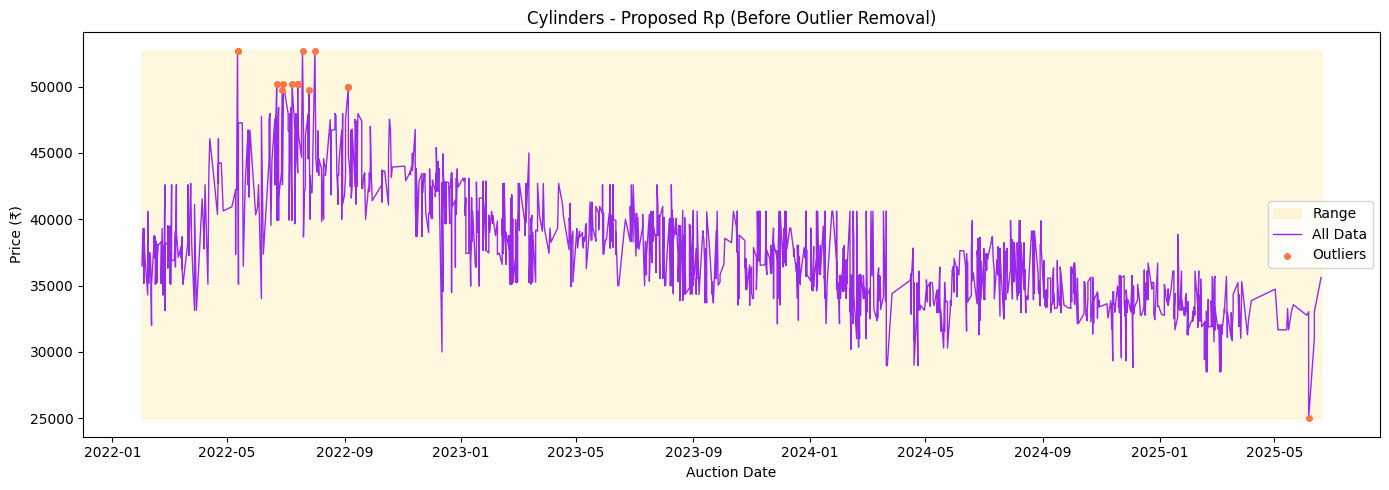

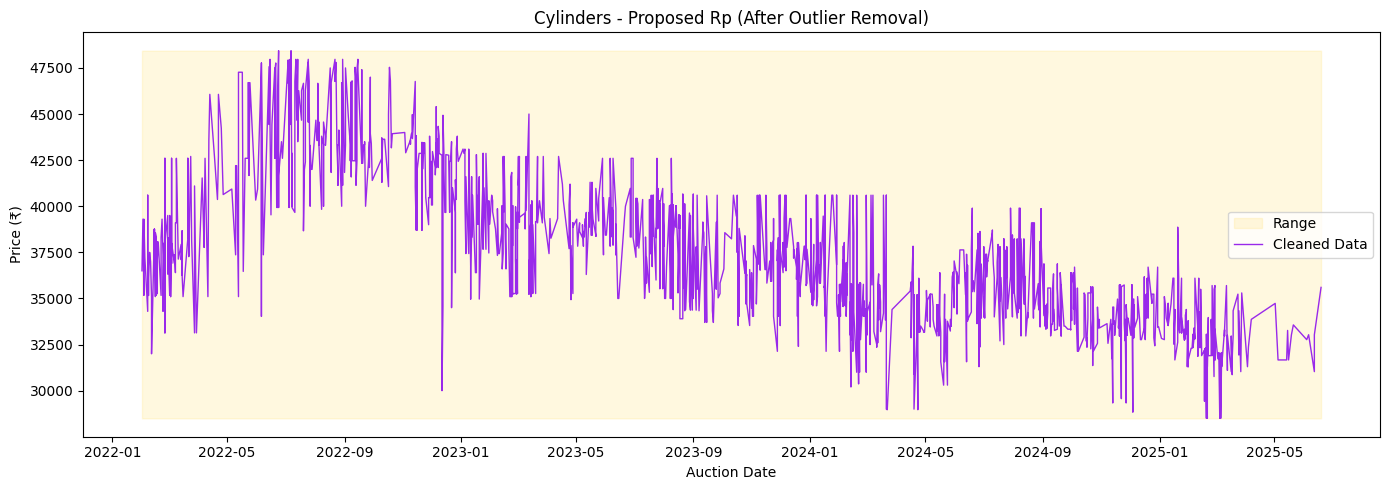

  Outliers removed: 15 / 2277 (0.66%)
  Cleaned records: 2262

--- Outlier Analysis: Cylinders - last_bid_price ---


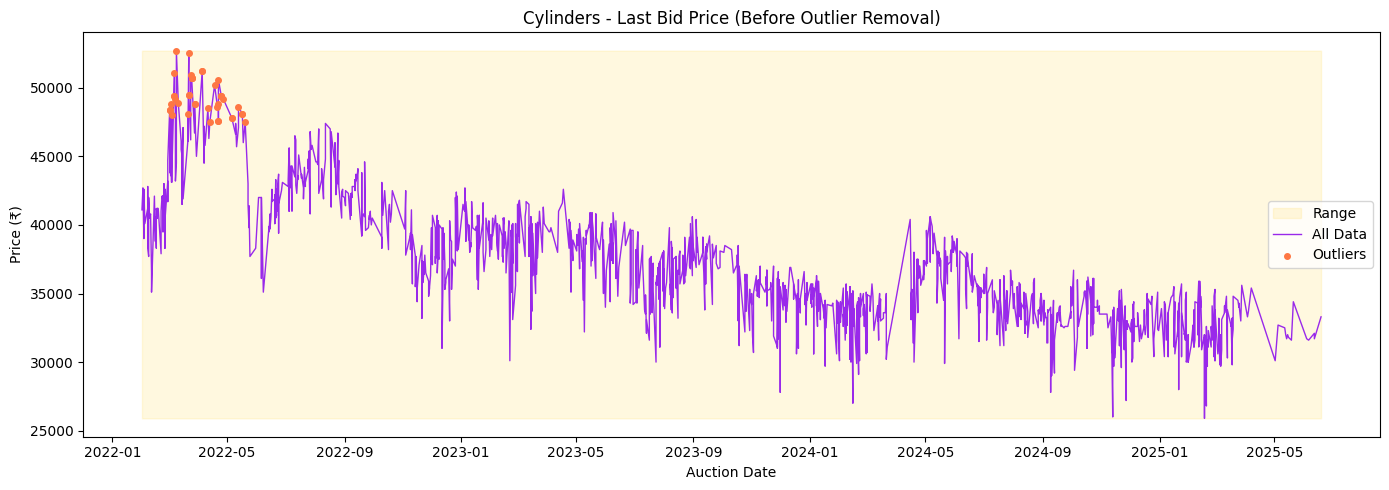

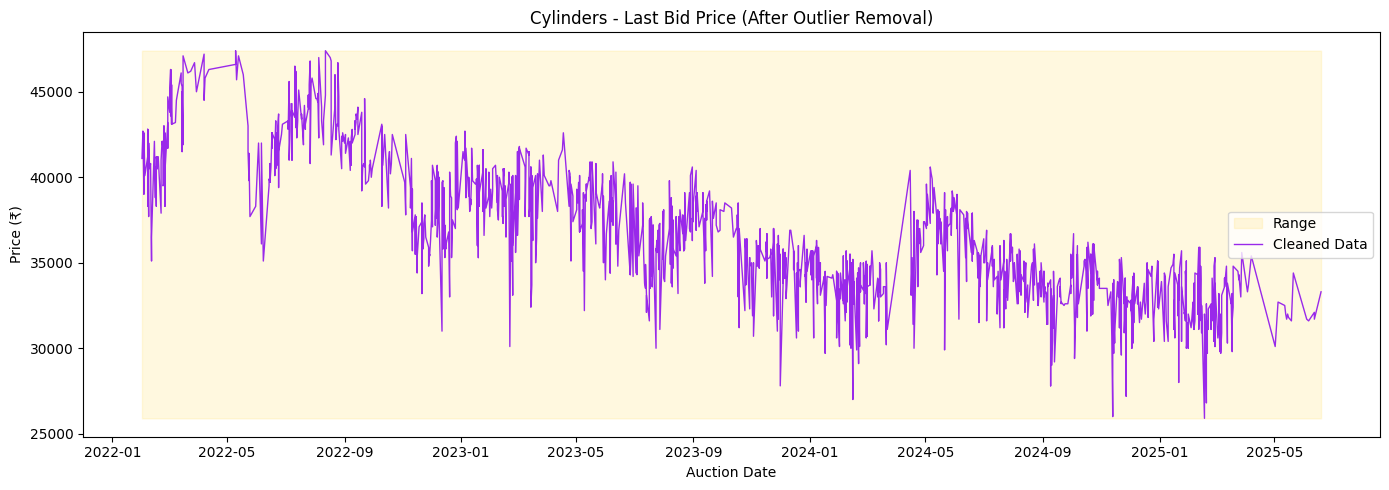

  Outliers removed: 41 / 2262 (1.81%)
  Cleaned records: 2221

--- Outlier Analysis: Valves - proposed_rp ---


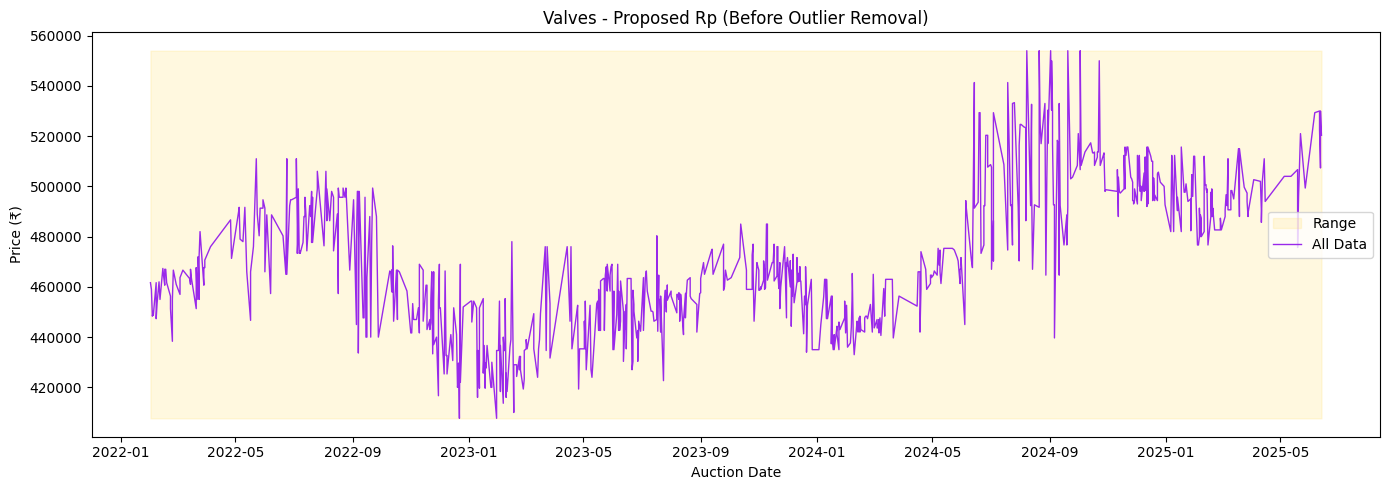

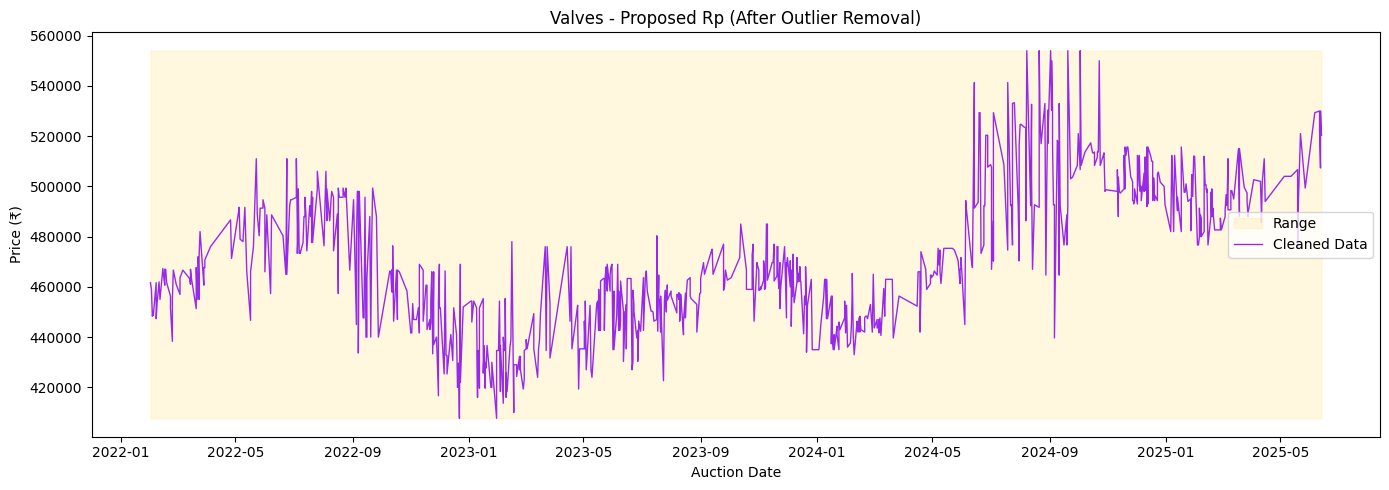

  Outliers removed: 0 / 805 (0.00%)
  Cleaned records: 805

--- Outlier Analysis: Valves - last_bid_price ---


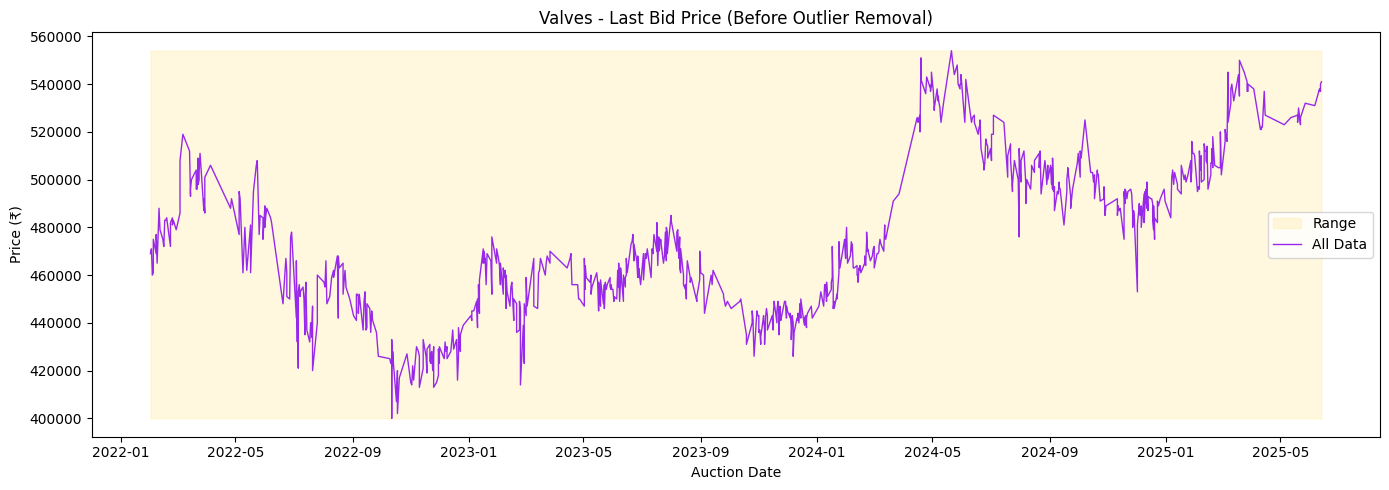

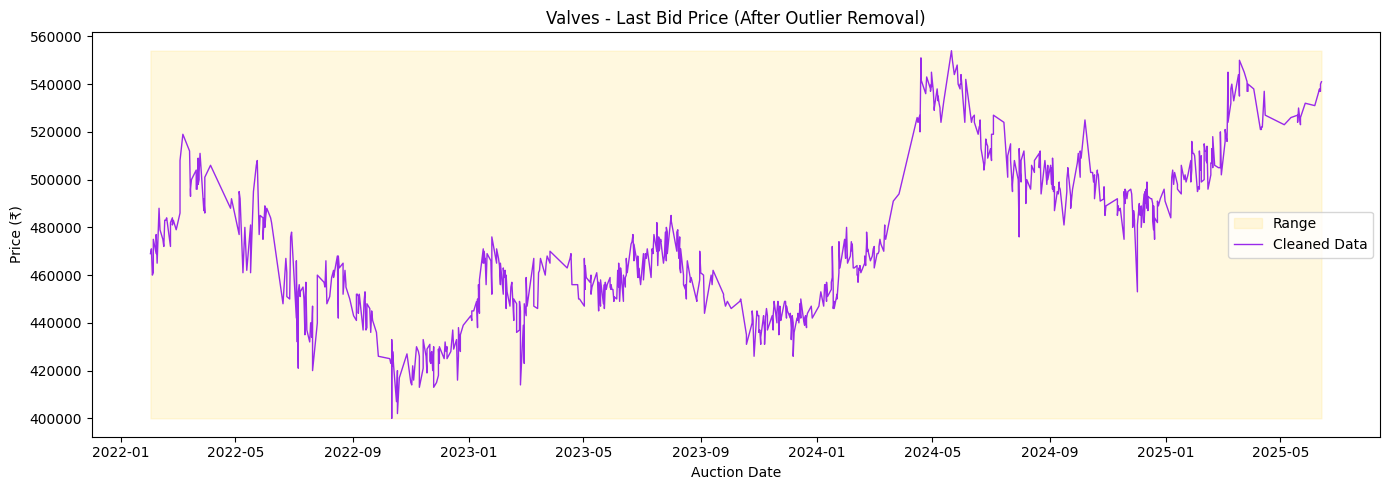

  Outliers removed: 0 / 805 (0.00%)
  Cleaned records: 805

Final cleaned data: 3366 records


In [9]:
trainer = AuctionModelTrainer(data_path='../data/AuctionData.xlsx')
df = trainer.load_and_preprocess_data()

In [11]:
outlier_records = []

for group in ['cylinders', 'valves']:
    for price_col in ['proposed_rp', 'last_bid_price']:
        group_df = df[df['product_group'] == group].copy()
        if group_df.empty or price_col not in group_df.columns:
            continue
        Q1 = group_df[price_col].quantile(0.25)
        Q3 = group_df[price_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_mask = (group_df[price_col] < lower) | (group_df[price_col] > upper)
        outliers = group_df[outlier_mask]
        if not outliers.empty:
            print(f"\nOutliers for {group.title()} - {price_col}:")
            print(outliers[['h1_buyer_name', 'auction_date', 'proposed_rp', 'last_bid_price']])
            outliers = outliers.assign(product_group=group, price_column=price_col)
            outlier_records.append(outliers[['product_group', 'price_column', 'h1_buyer_name', 'auction_date', 'proposed_rp', 'last_bid_price']])

# Optionally, save all outliers to Excel
if outlier_records:
    outlier_df = pd.concat(outlier_records)
    outlier_df.to_excel('../results/outlier_details.xlsx', index=False)
    print("All outlier details saved to ../results/outlier_details.xlsx")
else:
    print("No outliers found.")



Outliers for Cylinders - proposed_rp:
                                 h1_buyer_name auction_date  proposed_rp  \
3061  BANSAL ALLOYS AND METALS PRIVATE LIMITED   2022-07-07     48433.33   
3094  BANSAL ALLOYS AND METALS PRIVATE LIMITED   2022-06-24     48433.33   
3095  BANSAL ALLOYS AND METALS PRIVATE LIMITED   2022-06-24     48433.33   

      last_bid_price  
3061           44300  
3094           43700  
3095           43700  

Outliers for Cylinders - last_bid_price:
                                 h1_buyer_name auction_date  proposed_rp  \
2959  BANSAL ALLOYS AND METALS PRIVATE LIMITED   2022-08-12      43300.0   
3196  BANSAL ALLOYS AND METALS PRIVATE LIMITED   2022-05-10      42200.0   
3197  BANSAL ALLOYS AND METALS PRIVATE LIMITED   2022-05-10      42200.0   
3198  BANSAL ALLOYS AND METALS PRIVATE LIMITED   2022-05-10      42200.0   

      last_bid_price  
2959           47400  
3196           47400  
3197           47400  
3198           47400  
All outlier details saved 